In [1]:
import pandas as pd

dataset = pd.read_parquet("../dataset/test_math_exercice.parquet")
dataset

,problem,level,type,solution,id,source,category
0,What is the reciprocal of $0.\overline{714285}...,Level 5,Prealgebra,Let's first convert $0.\overline{714285}$ to a...,prealgebra_1148,test,5
1,Given that $\cos a = \frac{1}{3}$ and $\cos b ...,Level 3,Precalculus,"By product-to-sum,\n\[\cos (a + b) \cos (a - b...",precalculus_732,test,6
2,"If $a$ and $b$ are integers with $a > b$, what...",Level 5,Algebra,"Let $x = \frac{a+b}{a-b}$. Then, $\frac{a-b}{a...",algebra_595,train,0
3,Two numbers are said to be 'relatively prime' ...,Level 5,Prealgebra,"Since $28=2^2\cdot 7$, a positive integer is r...",prealgebra_1419,test,5
4,How many positive integers are less than $200\...,Level 2,Prealgebra,Based on our knowledge of the decimal expansio...,prealgebra_1891,test,5
...,...,...,...,...,...,...,...
2495,Define the function $f(x) = 2x - 5$. For what ...,Level 4,Algebra,Substituting $f^{-1}(x)$ into our expression f...,algebra_1450,train,0
2496,One-half of one-seventh of $T$ equals one-thir...,Level 3,Prealgebra,"From the problem, we write the equation \[\fra...",prealgebra_495,train,5
2497,Mr. Madoff invests 1000 dollars in a fund that...,Level 4,Algebra,Let $r$ be the annual interest rate. Then aft...,algebra_1014,test,0
2498,The volume of a cylinder is 60 cubic centimete...,Level 5,Geometry,We begin by drawing a diagram: [asy]\nimport s...,geometry_582,test,2


In [2]:
import torch
from sentence_transformers import SentenceTransformer, models

model = SentenceTransformer("../models/sbert-math-problem-ContrastiveLoss-cuda/", device='cpu')
model.to('cuda')
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 256, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)

In [3]:
BATCH_SIZE = 32

dataset["embedding_vector"] = pd.Series(
        model.encode(dataset["problem"], batch_size=BATCH_SIZE, device='cuda', show_progress_bar=True).tolist()
    )

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

In [4]:
from datetime import datetime
dataset['created_date']= datetime.today().strftime('%Y-%m-%d')
dataset.head(3)

,problem,level,type,solution,id,source,category,embedding_vector,created_date
0,What is the reciprocal of $0.\overline{714285}...,Level 5,Prealgebra,Let's first convert $0.\overline{714285}$ to a...,prealgebra_1148,test,5,"[0.012466754764318466, 0.10739056766033173, -0...",2023-09-22
1,Given that $\cos a = \frac{1}{3}$ and $\cos b ...,Level 3,Precalculus,"By product-to-sum,\n\[\cos (a + b) \cos (a - b...",precalculus_732,test,6,"[-0.0034363302402198315, 0.08205285668373108, ...",2023-09-22
2,"If $a$ and $b$ are integers with $a > b$, what...",Level 5,Algebra,"Let $x = \frac{a+b}{a-b}$. Then, $\frac{a-b}{a...",algebra_595,train,0,"[0.009845095686614513, -0.012728335335850716, ...",2023-09-22


In [5]:
dataset[dataset["id"]=="intermediate_algebra_2089"]

,problem,level,type,solution,id,source,category,embedding_vector,created_date


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   problem           2500 non-null   object  
 1   level             2500 non-null   object  
 2   type              2500 non-null   category
 3   solution          2500 non-null   object  
 4   id                2500 non-null   object  
 5   source            2500 non-null   object  
 6   category          2500 non-null   int32   
 7   embedding_vector  2500 non-null   object  
 8   created_date      2500 non-null   object  
dtypes: category(1), int32(1), object(7)
memory usage: 149.4+ KB


In [10]:
from opensearchpy import OpenSearch, RequestsHttpConnection

host = 'localhost'
port = 9200
auth = ('admin', 'admin') 

client = OpenSearch(
    hosts = [{'host': host, 'port': port}],
    http_compress = True, # enables gzip compression for request bodies
    http_auth = auth,
    use_ssl = True,
    verify_certs = False,
)

In [11]:
index_name = 'math-exercice'
index_body = {
    "mappings": {
        "properties": {
            "problem": {"type": "text"},
            "level": {"type": "text"},
            "type": {"type": "text"},
            "solution": {"type": "text"},
            "id": {"type": "text"},
            "source": {"type": "text"},
            "category": {"type": "integer"},
            "created_date": {"type": "date", "format": "yyyy-MM-dd"},
            "embedding_vector": {
                "type": "knn_vector",
                "dimension": 256
            }
        }
    }
}

response = client.indices.create(index_name, body=index_body)
print('\nCreating index:')
print(response)

C:\Users\Abdurrahman_Shahid\anaconda3\envs\stage\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(



Creating index:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'math-exercice'}


In [12]:
from pprint import pprint

documents = [
    {
            "problem": doc["problem"],
            "level": doc["level"],
            "type": doc["type"],
            "solution": doc["solution"],
            "id": doc["id"],
            "source": doc["source"],
            "category": doc["category"],
            "created_date": doc["created_date"],
            "embedding_vector": doc["embedding_vector"]
    }
    for _, doc in dataset.iterrows()
]

pprint(documents[:3])

[{'category': 5,
  'created_date': '2023-09-22',
  'embedding_vector': [0.012466754764318466,
                       0.10739056766033173,
                       -0.11800581961870193,
                       0.07028628885746002,
                       -0.09219158440828323,
                       -0.08459657430648804,
                       0.058190204203128815,
                       -0.07246341556310654,
                       0.10452862083911896,
                       -0.062575563788414,
                       -0.10683193057775497,
                       -0.03667931631207466,
                       0.013041844591498375,
                       -0.057696230709552765,
                       -0.006717165466398001,
                       0.07616379857063293,
                       -0.020801374688744545,
                       -0.022260719910264015,
                       -0.020964408293366432,
                       0.008250716142356396,
                       -0.008645243011415005,
      

In [13]:
def gendata(documents, index_name):
    for doc in documents:
        yield {
            "_op_type": "index",
            "_index": index_name,
            "_id": doc["id"],
            "_source": doc,
        }

In [14]:
documents_iterator = gendata(documents, index_name)

In [15]:
import logging
from opensearchpy import helpers

STREAM_BULK_KWARGS = {
    "max_retries": 3,
    "initial_backoff": 5,
    "max_backoff": 30,
    "raise_on_error": True,
    "raise_on_exception": True,
}

def os_streaming_bulk(client, documents_iterator):
    success, failed = 0, 0
    # list of errors to be collected is not stats_only
    errors = []
    for ok, item in helpers.streaming_bulk(client, documents_iterator, **STREAM_BULK_KWARGS):
        if not ok:
            errors.append(item)
            failed += 1
            logging.info("Opensearch streaming bulk failed")
        else:
            success += 1
    return {"success": success, "failed": failed, "errors": errors}

In [16]:
os_streaming_bulk(client, documents_iterator)

C:\Users\Abdurrahman_Shahid\anaconda3\envs\stage\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\Abdurrahman_Shahid\anaconda3\envs\stage\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\Abdurrahman_Shahid\anaconda3\envs\stage\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\U

{'success': 2500, 'failed': 0, 'errors': []}

In [17]:
body = {
    "size": 3,
    "query": {
        "match_all": {}
    }
}
res = client.search(body=body, index=index_name)
pprint(res)

{'_shards': {'failed': 0, 'skipped': 0, 'successful': 1, 'total': 1},
 'hits': {'hits': [{'_id': 'prealgebra_1148',
                    '_index': 'math-exercice',
                    '_score': 1.0,
                    '_source': {'category': 5,
                                'created_date': '2023-09-22',
                                'embedding_vector': [0.012466754764318466,
                                                     0.10739056766033173,
                                                     -0.11800581961870193,
                                                     0.07028628885746002,
                                                     -0.09219158440828323,
                                                     -0.08459657430648804,
                                                     0.058190204203128815,
                                                     -0.07246341556310654,
                                                     0.10452862083911896,
                     

C:\Users\Abdurrahman_Shahid\anaconda3\envs\stage\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [18]:
def tfidf_more_like_this_retrieval(doc_id, top_k=10, client=client):
    body = {
        "size": top_k,
        "query" : {
            "more_like_this" : {
                "fields" : ["problem"],
                "like": {
                    "_index": index_name,
                    "_id": doc_id
                },
                "min_term_freq": 1,
                "max_query_terms": 50,
            }
        },
        "_source": ["id", "category", "level", "type", "problem", "solution", "date"],
    }
    
    results = client.search(body=body, index=index_name)
    results = results['hits']['hits']
    results = [{"score": r["_score"], **r["_source"]} for r in results]
    
    return results

In [19]:
from IPython.display import display, Latex

exercice = dataset.iloc[1]

results = tfidf_more_like_this_retrieval(exercice["id"])
print(exercice["id"])
display(Latex(exercice["problem"]))

for i, result in enumerate(results):
    display(Latex('-'*20+'METADATA'+'-'*20))
    print(i, result["score"])
    display(Latex("ID: "+ result['id']))
    display(Latex("Type: "+ result['type']))
    display(Latex("Level: " + result['level']))
    display(Latex('-'*20+'EXERCICE'+'-'*20))
    display(Latex(result['problem']))
    display(Latex('-'*20+'SOLUTION'+'-'*20))
    display(Latex(result['solution']))
    display(Latex('='*100))
    print("\n")

precalculus_732


C:\Users\Abdurrahman_Shahid\anaconda3\envs\stage\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

0 17.92553


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

1 17.740059


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

2 17.631618


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

3 15.726496


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

4 15.462423


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

5 15.062452


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

6 15.022429


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

7 15.0115385


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

8 14.577801


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

9 13.67694


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [20]:
def similar_documents_retrieval(query, top_k=10, client=client, model=model):
    query_embedding = model.encode(query)

    body = {
        "size": top_k+1,
        "_source": ["id", "category", "level", "type", "problem", "solution", "date"],
        "query": {
            "script_score": {
                "query": {
                    "match_all": {}
                },
                "script": {
                    "source": "knn_score",
                    "lang": "knn",
                    "params": {
                        "field": "embedding_vector",
                        "query_value": query_embedding.tolist(),
                        "space_type": "cosinesimil"
                    }
                }
            }
        }
    }

    results = client.search(body=body, index=index_name)
    results = results['hits']['hits']
    results = [{"score": r["_score"], **r["_source"]} for r in results]
    
    return results

In [21]:
from IPython.display import display, Latex

results = similar_documents_retrieval(query="exercice with circles and volumes")

for i, result in enumerate(results):
    display(Latex('-'*20+'METADATA'+'-'*20))
    print(i, result["score"])
    display(Latex("Type: "+ result['type']))
    display(Latex("Level: " + result['level']))
    display(Latex('-'*20+'EXERCICE'+'-'*20))
    display(Latex(result['problem']))
    display(Latex('-'*20+'SOLUTION'+'-'*20))
    display(Latex(result['solution']))
    display(Latex('='*100))
    print("\n")

C:\Users\Abdurrahman_Shahid\anaconda3\envs\stage\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<IPython.core.display.Latex object>

0 1.8379517


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

1 1.8135598


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

2 1.8134861


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

3 1.8128603


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

4 1.8105705


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

5 1.8041501


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

6 1.8016241


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

7 1.8010623


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

8 1.7984926


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

9 1.7966745


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

10 1.7965082


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [22]:
results = similar_documents_retrieval(query="exercice on probability")

for i, result in enumerate(results):
    display(Latex('-'*20+'METADATA'+'-'*20))
    print(i, result["score"])
    display(Latex("Type: "+ result['type']))
    display(Latex("Level: " + result['level']))
    display(Latex('-'*20+'EXERCICE'+'-'*20))
    display(Latex(result['problem']))
    display(Latex('-'*20+'SOLUTION'+'-'*20))
    display(Latex(result['solution']))
    display(Latex('='*100))
    print("\n")

C:\Users\Abdurrahman_Shahid\anaconda3\envs\stage\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<IPython.core.display.Latex object>

0 1.9636564


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

1 1.9609728


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

2 1.9594308


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

3 1.9589915


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

4 1.9586942


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

5 1.957789


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

6 1.9574779


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

7 1.9571857


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

8 1.9569631


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

9 1.9560969


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

10 1.9552915


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [24]:
dataset["id"]

0                    prealgebra_1148
1                    precalculus_732
2                        algebra_595
3                    prealgebra_1419
4                    prealgebra_1891
                    ...             
2495                    algebra_1450
2496                  prealgebra_495
2497                    algebra_1014
2498                    geometry_582
2499    counting_and_probability_407
Name: id, Length: 2500, dtype: object

In [25]:
#recommend similar exercices
exercice = dataset.loc[dataset["id"]=="prealgebra_1148"].iloc[0]["problem"]
display(Latex(exercice))

<IPython.core.display.Latex object>

In [26]:
results = similar_documents_retrieval(query=exercice)
for i, result in enumerate(results):
    display(Latex('-'*20+'METADATA'+'-'*20))
    print(i, result["score"])
    display(Latex("Type: "+ result['type']))
    display(Latex("Level: " + result['level']))
    display(Latex('-'*20+'EXERCICE'+'-'*20))
    display(Latex(result['problem']))
    display(Latex('-'*20+'SOLUTION'+'-'*20))
    display(Latex(result['solution']))
    display(Latex('='*100))
    print("\n")

C:\Users\Abdurrahman_Shahid\anaconda3\envs\stage\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<IPython.core.display.Latex object>

0 2.0


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

1 1.9301172


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

2 1.925859


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

3 1.9164495


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

4 1.9079633


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

5 1.9075752


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

6 1.9026763


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

7 1.9020948


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

8 1.8990431


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

9 1.8966032


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

10 1.896177


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [27]:
from IPython.display import display, Latex
#recommend similar exercices
idx=0
print(dataset.iloc[idx][["category", "type"]])
exercice = dataset.iloc[idx]["problem"]
display(Latex(exercice))

category             5
type        Prealgebra
Name: 0, dtype: object


<IPython.core.display.Latex object>

In [28]:
results = similar_documents_retrieval(query=exercice)
for i, result in enumerate(results):
    display(Latex('-'*20+'METADATA'+'-'*20))
    print(i, result["score"])
    display(Latex("Type: "+ result['type']))
    display(Latex("Level: " + result['level']))
    display(Latex('-'*20+'EXERCICE'+'-'*20))
    display(Latex(result['problem']))
    display(Latex('-'*20+'SOLUTION'+'-'*20))
    display(Latex(result['solution']))
    display(Latex('='*100))
    print("\n")

C:\Users\Abdurrahman_Shahid\anaconda3\envs\stage\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<IPython.core.display.Latex object>

0 2.0


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

1 1.9301172


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

2 1.925859


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

3 1.9164495


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

4 1.9079633


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

5 1.9075752


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

6 1.9026763


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

7 1.9020948


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

8 1.8990431


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

9 1.8966032


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

10 1.896177


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [29]:
def precision_at_k(ranked_list, label, k):
    all_items = ranked_list[:k]
    item_is_relevant = [item==label for item in all_items]
    return sum(item_is_relevant)/len(all_items)

In [30]:
for k_ in range(1, 8):
    print(precision_at_k([2, 2, 1, 3, 2, 4, 1, 1], label=1, k=k_))

0.0
0.0
0.3333333333333333
0.25
0.2
0.16666666666666666
0.2857142857142857


In [31]:
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict
import time



precisions_knn = defaultdict(list)
precisions_tfidf = defaultdict(list)

knn_execution_time = []
tfidf_execution_time = []

for _, exercice in dataset.iterrows():
    
    start_time = time.time()
    results_knn = similar_documents_retrieval(exercice["problem"])
    knn_execution_time.append(time.time() - start_time)
    results_cat_knn = [r['category'] for r in results_knn if r["id"]!=exercice["id"]]
    
    start_time = time.time()
    results_tfidf = tfidf_more_like_this_retrieval(exercice["id"])
    tfidf_execution_time.append(time.time() - start_time)
    results_cat_tfidf =[r['category'] for r in results_tfidf]
    
    for k_ in range(1, 11):
        precisions_knn[f"@{str(k_)}"].extend([precision_at_k(results_cat_knn, exercice["category"], k=k_)])
        precisions_tfidf[f"@{str(k_)}"].extend([precision_at_k(results_cat_tfidf, exercice["category"], k=k_)])

In [32]:
precisions_at_k_knn = {}
precisions_at_k_tfidf = {}

for k_ in range(1, 11):
    print(f"Precision at {k_}: ")
    precision_list_knn = precisions_knn[f"@{str(k_)}"]
    precision_at_k_knn = sum(precision_list_knn)/len(precision_list_knn)
    precisions_at_k_knn[f"@{k_}"] = precision_at_k_knn
    print(precision_at_k_knn)
    precision_list_tfidf = precisions_tfidf[f"@{str(k_)}"]
    precision_at_k_tfidf = sum(precision_list_tfidf)/len(precision_list_tfidf)
    precisions_at_k_tfidf[f"@{k_}"] = precision_at_k_tfidf
    print(precision_at_k_tfidf)

Precision at 1: 
0.698
0.6328
Precision at 2: 
0.6878
0.6106
Precision at 3: 
0.680933333333335
0.5916000000000018
Precision at 4: 
0.6778
0.5774
Precision at 5: 
0.6739199999999966
0.5657799999999986
Precision at 6: 
0.6715333333333313
0.5539666666666665
Precision at 7: 
0.668114285714288
0.543242857142858
Precision at 8: 
0.6676
0.5366
Precision at 9: 
0.667200000000005
0.5300111111111128
Precision at 10: 
0.6662000000000019
0.5210422222222225


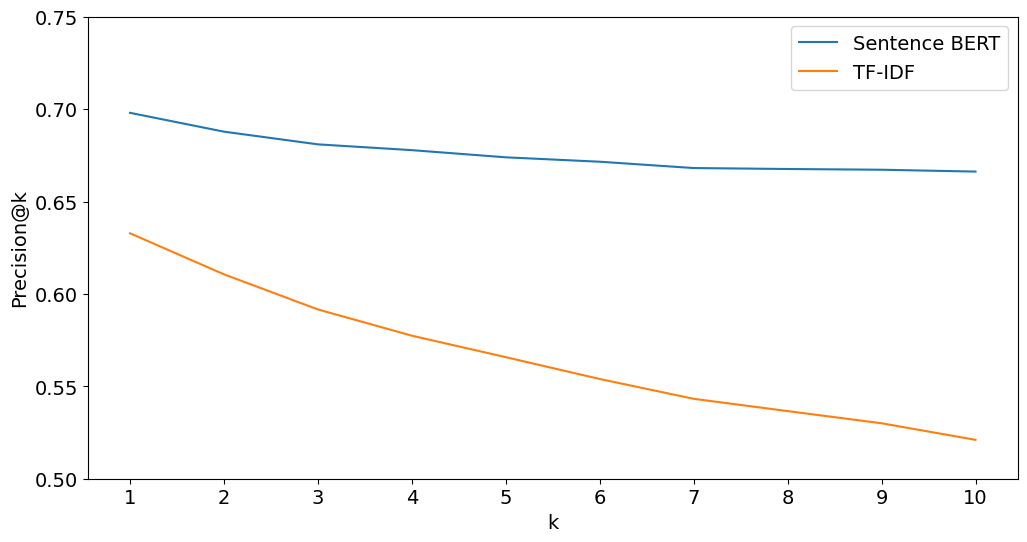

In [57]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.plot(list(range(1, 11)), list(precisions_at_k_knn.values()), label="Sentence BERT")
plt.plot(list(range(1, 11)), list(precisions_at_k_tfidf.values()), label="TF-IDF")
plt.ylim(0.5,0.75)
plt.yticks(fontsize=14)
plt.xticks(np.arange(1, 11, 1.0), fontsize=14)
plt.ylabel("Precision@k", fontsize=14)
plt.xlabel("k", fontsize=14)
plt.legend(loc='upper right', fontsize=14)
#plt.savefig("precision_at_k_10.png", dpi=600, bbox_inches="tight")
plt.show()

In [54]:
pd.DataFrame({"Sbert":list(precisions_at_k_knn.values()), "tf-idf": list(precisions_at_k_tfidf.values())},
             index=np.arange(1, 11, 1.0))

,Sbert,tf-idf
1.0,0.698000,0.632800
2.0,0.687800,0.610600
3.0,0.680933,0.591600
4.0,0.677800,0.577400
5.0,0.673920,0.565780
6.0,0.671533,0.553967
7.0,0.668114,0.543243
8.0,0.667600,0.536600
9.0,0.667200,0.530011
10.0,0.666200,0.521042


In [48]:
#knn_execution_time

In [43]:
#sum(knn_execution_time)

267.91059970855713

In [44]:
#sum(tfidf_execution_time)

133.46539521217346

In [46]:
# average query execution time
sum(knn_execution_time)/len(knn_execution_time)

0.10716423988342286

In [49]:
# average query execution time
sum(tfidf_execution_time)/len(tfidf_execution_time)

0.053386158084869385

In [ ]:
import pandas as pd

precisions_df = pd.DataFrame({'precision_at_k': list(range(1, 11)),
                   'knn': list(precisions_at_k_knn.values()),
                   'tfidf': list(precisions_at_k_tfidf.values())})

In [ ]:
!pip install seaborn

In [ ]:
import seaborn as sns

sns.lineplot(data=precisions_df[['knn', 'tfidf']])

In [59]:
response = client.indices.delete(
    index = index_name
)

print('\nDeleting index:')
print(response)

NotFoundError: NotFoundError(404, 'index_not_found_exception', 'no such index [math-exercice]', math-exercice, index_or_alias)